# How to Use the Unit System

**Important: The unit system is a feature under development. The following section might not work properly yet.**

Here, we show some examples using the unit system in `ecell4`. This feature requires Python library, `pint`. Install `pint` before running this example as follows: `pip install pint`. See also the website https://pint.readthedocs.io/en/latest/.

In [1]:
%matplotlib inline
from ecell4.prelude import *

## With no units

First, imagine a very simple system only with binding and unbinding reactions like:

In [2]:
with species_attributes():
    A | B | C | {'D': 1, 'radius': 0.005}

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

The `species_attributes` section defines a diffusion constant and radius of `Species`, `A`, `B` and `C`. For example, the diffusion rate of `A` is `1`, and its dimensionality is expected to be `[length**2/time]`. However, what is the scale? Is it `meter`? Or `mile`?

Once the base units are determined, e.g. `micrometer` as `[length]` and `second` as `[time]`, all the units must be consistent within the model. The second order rate consant must have dimensionality `[1/(substance/length**3)/time]`, which is `micrometer**3/item/second`. Thus, when the parameter is given as `1/molar/min` in some literature, you have to translate it by yourself.

In [3]:
show(m)

A | {'D': 1, 'radius': 0.005}
B | {'D': 1, 'radius': 0.005}
C | {'D': 1, 'radius': 0.005}

A + B > C | 0.01
C > A + B | 0.3


## Introducing units

`ecell4` provides the way to handle units in the modeling environment. Here is an example.

In [4]:
from ecell4.extra.unit import getUnitRegistry
ureg = getUnitRegistry()
Q_ = ureg.Quantity

First, create your own unit system,`ureg`, by using `ecell4.extra.unit.getUnitRegistry`. With this `UnitRegistry`, you can make a quantity with its unit as `ureg.Quantity(value, unit)`. (Please be careful about the type of `Quantity`. It looks same with `Quantity` given by `pint`, but is slightly changed in `ecell4` though all the original functionality in `pint` is availble even in `ecell4`. Please not use `ureg = pint.UnitRegistry()`.)

In [5]:
with species_attributes():
    A | B | C | {'D': Q_(1, 'um**2/s'), 'radius': Q_(0.005, 'um')}

with reaction_rules():
    A + B == C | (Q_(0.01, '1/(item/um**3)/s'), Q_(0.3, '1/s'))

m = get_model()

The default base units are `meter` for `[length]`, `second` for `[time]`, and `item` (which means the number of molecules) for `[substance]`. When you change the default base unit, do like `ureg = getUnitRegistry(length='micrometer')`.

In [6]:
show(m)

A | {'D': Quantity_Real(1e-12, 'meter ** 2 / second'), 'radius': Quantity_Real(5e-09, 'meter')}
B | {'D': Quantity_Real(1e-12, 'meter ** 2 / second'), 'radius': Quantity_Real(5e-09, 'meter')}
C | {'D': Quantity_Real(1e-12, 'meter ** 2 / second'), 'radius': Quantity_Real(5e-09, 'meter')}

A + B > C | Quantity_Real(1e-20, 'meter ** 3 / item / second')
C > A + B | Quantity_Real(0.3, '1 / second')


Now you can provide quantities in any unit regardless of the base units.

In [7]:
with species_attributes():
    A | B | C | {'D': Q_(1e-8, 'cm**2/s'), 'radius': Q_(5, 'nm')}

with reaction_rules():
    A + B == C | (Q_(6.02214129, '1/uM/s'), Q_(18, '1/min'))

m = get_model()
show(m)

A | {'D': Quantity_Real(1e-12, 'meter ** 2 / second'), 'radius': Quantity_Real(5e-09, 'meter')}
B | {'D': Quantity_Real(1e-12, 'meter ** 2 / second'), 'radius': Quantity_Real(5e-09, 'meter')}
C | {'D': Quantity_Real(1e-12, 'meter ** 2 / second'), 'radius': Quantity_Real(5e-09, 'meter')}

A + B > C | Quantity_Real(1e-20, 'meter ** 3 / item / second')
C > A + B | Quantity_Real(0.3, '1 / second')


You can operate quantities, and make a new quantity. See https://pint.readthedocs.io/en/latest/ for more details.

In [8]:
volume = Q_(1, 'fL')
conc = Q_(100, 'nM')
print((volume * conc).to('item'))

60.221412900000004 item


In addition to the model creation, `run_simulation` (and `ensemble_simulations`) also supports the unit system.

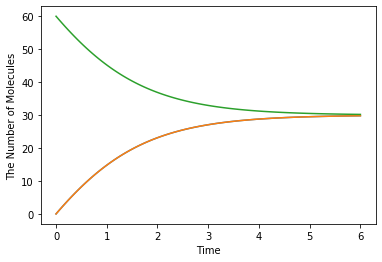

In [9]:
run_simulation(Q_(0.1, 'min'), y0={'C': Q_(60, 'item')}, volume=Q_(1, 'fL'), model=m, solver='ode')

Even if you change the base units, the behavior of simulations is kept consistent. In the following example, base units are rescaled to `micrometer` and `minute` with no change in the modeling section.

A | {'D': Quantity_Real(60, 'micrometer ** 2 / minute'), 'radius': Quantity_Real(0.005, 'micrometer')}
B | {'D': Quantity_Real(60, 'micrometer ** 2 / minute'), 'radius': Quantity_Real(0.005, 'micrometer')}
C | {'D': Quantity_Real(60, 'micrometer ** 2 / minute'), 'radius': Quantity_Real(0.005, 'micrometer')}

A + B > C | Quantity_Real(0.6, 'micrometer ** 3 / item / minute')
C > A + B | Quantity_Real(18, '1 / minute')


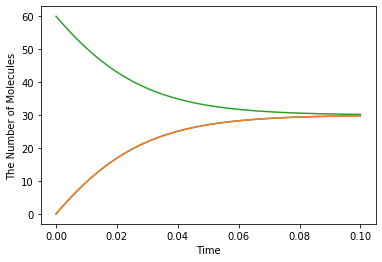

In [10]:
ureg = getUnitRegistry(length='micrometer', time='minute')
Q_ = ureg.Quantity

with species_attributes():
    A | B | C | {'D': Q_(1e-8, 'cm**2/s'), 'radius': Q_(5, 'nm')}

with reaction_rules():
    A + B == C | (Q_(6.02214129, '1/uM/s'), Q_(18, '1/min'))

m = get_model()
show(m)
run_simulation(Q_(0.1, 'min'), y0={'C': Q_(60, 'item')}, volume=Q_(1, 'fL'), model=m, solver='ode')

## Checking dimensionality

<div class="alert alert-warning">

This feature is still being developed. Please report issues when getting the wrong behavior.

</div>

You can check units in the model by `ecell4.extra.unit.check_model`.

For example, the dimensionality of a diffusion constant must be `[length**2/time]`. When you give a unit with a wrong dimensionality, an exception `DimensionalityMismatchError` would be thrown as:

In [11]:
from ecell4.extra.unit import check_model, DimensionalityMismatchError
ureg = getUnitRegistry()
Q_ = ureg.Quantity

In [12]:
with species_attributes():
    A | {'radius': Q_(0.005, 'um'), 'D': Q_(1.0, 'um/s')}

try:
    check_model(get_model())
except DimensionalityMismatchError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityMismatchError: Attribute [D] in Species [A] has wrong dimensionality. [[length]**2/[time]] is expected.


When checking dimensionality of units in the model by `check_model`, you can omit no unit.

In [13]:
with species_attributes():
    A | {'radius': 0.005, 'D': Q_(1.0, 'um**2/s')}

try:
    check_model(get_model())
except DimensionalityMismatchError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityMismatchError: Attribute [radius] in Species [A] has wrong dimensionality. [[length]] is expected.


A kinetic rate constant of reactions is verified based on the order of the reaction. The first order reaction rate should have `[1/time]`, and the second order should have `[l/(substance/length**3)/time]` in volume.

In [14]:
with reaction_rules():
    A + B > C | Q_(0.3, '1/s')

try:
    check_model(get_model())
except DimensionalityMismatchError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityMismatchError: ReactionRule [A+B>C|0.3] has wrong dimensionality [1 / [time]]. [[length]**3/[substance]/[time]] is expected.


The dimensionality of a synthetic reaction depends on the dimension which the products belongs to.

In [15]:
with reaction_rules():
    ~A > A | Q_(0.3, '1/s')

try:
    check_model(get_model())
except DimensionalityMismatchError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityMismatchError: ReactionRule [>A|0.3] has wrong dimensionality [1 / [time]]. [[substance]/[time]/[length]**3] is expected.


An unit of the reaction rate between a molecule and structure is also tested.

In [16]:
with species_attributes():
    B | {'location': 'M'}
    M | {'dimension': 2}

with reaction_rules():
    A + M > B | Q_(0.3, '1/s')

try:
    check_model(get_model())
except DimensionalityMismatchError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityMismatchError: ReactionRule [A+M>B|0.3] has wrong dimensionality [1 / [time]]. [[length]**1/[time]] is expected.


Additionally, rate law representations accept quantities with a unit too. See the example below:

In [17]:
with reaction_rules():
    S > P | Q_(1.0, 'uM/s') * S / (Q_(100, 'nM') + S)

check_model(get_model())

Here, the reaction above has two quantities, `Vmax = Q_(1.0, 'uM/s')` and `Km = Q_(100, 'nM')`. First, `Km` must have the same dimensionality with `S`, which is `[concentration]`.

In [18]:
with reaction_rules():
    S > P | Q_(1.0, 'uM/s') * S / (Q_(100, 'nM/s') + S)

try:
    check_model(get_model())
except DimensionalityMismatchError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityMismatchError: Failed to evaluate [((Quantity_Real(6.02214129e+20, 'item / meter ** 3 / second') * S) / (Quantity_Real(6.02214129e+19, 'item / meter ** 3 / second') + S))] (1*S>1*P|0). Cannot convert from 'item / meter ** 3 / second' ([substance] / [length] ** 3 / [time]) to 'item / meter ** 3' ([substance] / [length] ** 3)


Secondly, the dimensionality of a rate equation must be `[concentration/time]`. Therefore, the dimensionality of `Vmax` should be `[concentration/time]` too.

In [19]:
with reaction_rules():
    S > P | Q_(1.0, '1/s') * S / (Q_(100, 'nM') + S)

try:
    check_model(get_model())
except DimensionalityMismatchError as e:
    print('{}: {}'.format(e.__class__.__name__, e))

DimensionalityMismatchError: ReactionRule [1*S>1*P|0] has wrong dimensionality [1 / [time]]. [[substance]/[length]**3/[time]] is expected.


When you give a value with no unit, it is regarded as `dimensionless`.

In [20]:
with reaction_rules():
    S > P | 10.0 * Q_(0.1, 'uM/s') * S**2 / (Q_(100, 'nM')**2 + S**2)

m = get_model()
show(m)
check_model(m)


S > P | ((Quantity_Real(6.02214129e+20, 'item / meter ** 3 / second') * pow(S, 2)) / (Quantity_Real(3.626618571672287e+39, 'item ** 2 / meter ** 6') + pow(S, 2)))
